# Download the spectra for each source

In [161]:
%matplotlib inline
import sys, os, glob, copy, re

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import ligo.skymap.plot
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

read files

In [230]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')
data_agn_compare = ascii.read('hsc_agn_compare.txt')
data_agn = ascii.read('hsc_agn.txt')

prepare a table for downloading flag (?) 

In [528]:
data_agn_download = copy.deepcopy(data_agn_updated)

plot the table in a skymap

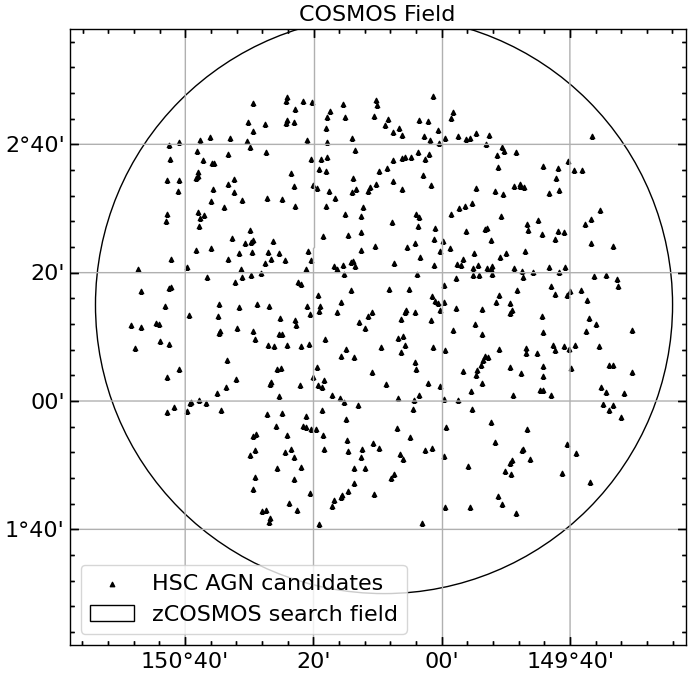

In [347]:
ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='HSC AGN candidates')

circle = plt.Circle((150.15, 2.25), 0.75, fill=False, transform=ax1.get_transform('world'), label='zCOSMOS search field')
ax1.add_artist(circle)

ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(frameon=True)
ax1.set_title('COSMOS Field')

plt.show()

### Dataset overview

The following sources have a publically available spectra

* Magellean/zCOSMOS
* DEIMOS
* SDSS

The following sources need more inspection: 

* HSC PDR3: it consists of many sources that may or may not be available


## Magellean

inquiry website: https://irsa.ipac.caltech.edu/data/COSMOS/

We first download all the spectra and match it into our catalog. 

Put `150.15 2.25` into `Coordinates/Object`, `2` into `Image Search Size (deg)` (whatever but `2` runs the fastest), `0.75 deg` into `Source Search Radius`, check `Images must cover coordinate`and uncheck `Match with image search size`, and submit, and then download `magellan_opt_spec_30.tbl`. It contains all the coordinates and links of the spectra we may want to use. 

Then, we match it into our catalog. 

In [624]:
magellean_targets = ascii.read('spec/magellan_opt_spec_30.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(magellean_targets)): 
    for key in ['TBL', 'FITS', 'SPEC_Preview_JPG']: 
        magellean_targets[key][i] = pattern.findall(magellean_targets[key][i])[0]

magellean_coords = SkyCoord(magellean_targets['ra'], magellean_targets['dec'], unit=[u.deg, u.deg])
idx_magellean, idx_data, d2d, _ = data_coords.search_around_sky(magellean_coords, 0.5*u.arcsec)

len(idx_magellean), len(np.unique(idx_data))

(205, 204)

Fill in the downloading table. 

In [639]:
data_agn_download['flag_magellean'] = False
data_agn_download['z_magellean'] = -1.

for i in range(len(data_agn_download)): 
    if i in idx_data: 
        data_agn_download['flag_magellean'][i] = True
        data_agn_download['z_magellean'][i] = magellean_targets['redshift'][i]

Download the data. The whole precess takes ~2 mins. UNCOMMENT IF YOU NEED TO DOWNLOAD AGAIN. 

Naming convention: `magellean_<ID>.fits` (ID not index)

In [ ]:
magellean_dir = 'spec/Magellean'
magellean_id = data_agn_download[idx_data]['ID']
magellean_links = magellean_targets[idx_magellean]['FITS']

for i in range(len(magellean_id)): 
    os.system('wget '+magellean_links[i]+' -O '+os.path.join(magellean_dir, 'magellean_'+str(magellean_id[i])+'.fits'))

Note: 

* Magellean has 205/1240 targets matched, which is less than zCOSMOS has 236/20098 matches. 
* ID=153 has multiple returns, checked below and sample spectra section 
  * The two matches have the same spectra link, which supports z=0.695

In [637]:
magellean_targets[idx_magellean[idx_data==152]]

Object_Name,ra,dec,imag,SN,expi,expm,class,redshift,z_err,z_conf,field,filename,TBL,FITS,SPEC_Preview_JPG
str12,float64,float64,float64,float64,int64,int64,str4,float64,float64,int64,str5,str39,str151,str154,str256
00117+023309,150.3237457,2.552633,22.34,2.5,9000,0,nl,1.0013,0.0004,4,i1f7,magellan_opt_100117+023309_spec_31.fits,https://irsa.ipac.caltech.edu:443/data/COSMOS/spectra/magellan/tbl/magellan_opt_100117+023309_spec_30.tbl,https://irsa.ipac.caltech.edu:443/data/COSMOS/spectra/magellan/fits/magellan_opt_100117+023309_spec_31.fits,/data/COSMOS/spectra/magellan/jpg/magellan_opt_100117+023309_spec_30.jpg
00117+023309,150.3238525,2.5526006,22.6,20.18,18000,0,nl,0.695,0.0038,4,i3F3,magellan_opt_100117+023309_spec_31.fits,https://irsa.ipac.caltech.edu:443/data/COSMOS/spectra/magellan/tbl/magellan_opt_100117+023309_spec_30.tbl,https://irsa.ipac.caltech.edu:443/data/COSMOS/spectra/magellan/fits/magellan_opt_100117+023309_spec_31.fits,/data/COSMOS/spectra/magellan/jpg/magellan_opt_100117+023309_spec_30.jpg


### zCOSMOS

DO NOT RUN THIS PART because zCOSMOS is overlapped with Magellen

In [621]:
zcosmos_targets = ascii.read('spec/zcosmosdr3.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(zcosmos_targets)): 
    for key in ['Spectrum_FITS', 'Spectrum_TBL', 'Spectrum_Preview', 'HST_stamp_jpg', 'HST_stamp_fits']: 
        zcosmos_targets[key][i] = pattern.findall(zcosmos_targets[key][i])[0]

zcosmos_coords = SkyCoord(zcosmos_targets['ra'], zcosmos_targets['dec'], unit=[u.deg, u.deg])
idx_zcosmos, idx_data, d2d, _ = data_coords.search_around_sky(zcosmos_coords, 0.5*u.arcsec)

len(idx_zcosmos), len(np.unique(idx_data))

(236, 236)

Fill the flag in the downloading table. 

In [530]:
data_agn_download['flag_zcosmos'] = False

for i in range(len(data_agn_download)): 
    if i in idx_data: 
        data_agn_download['flag_zcosmos'][i] = True

Download the data. The whole precess takes ~3 mins. UNCOMMENT IF YOU NEED TO DOWNLOAD AGAIN. 

Naming convention: `zcosmos_<ID>.fits` (ID not index)

In [ ]:
# zcosmos_dir = 'spec/zCOSMOS'
# zcosmos_id = data_agn_download[idx_data]['ID']
# zcosmos_links = zcosmos_targets[idx_zcosmos]['Spectrum_FITS']

# for i in range(len(zcosmos_id)): 
#     os.system('wget '+zcosmos_links[i]+' -O '+os.path.join(zcosmos_dir, 'zcosmos_'+str(zcosmos_id[i])+'.fits'))

### Sample spectra

Compare one of the inconsistent sources to the template AGN spectrum

template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.57291667, 2.38752778)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.7202, 2.248003)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.72016667, 2.248)>)

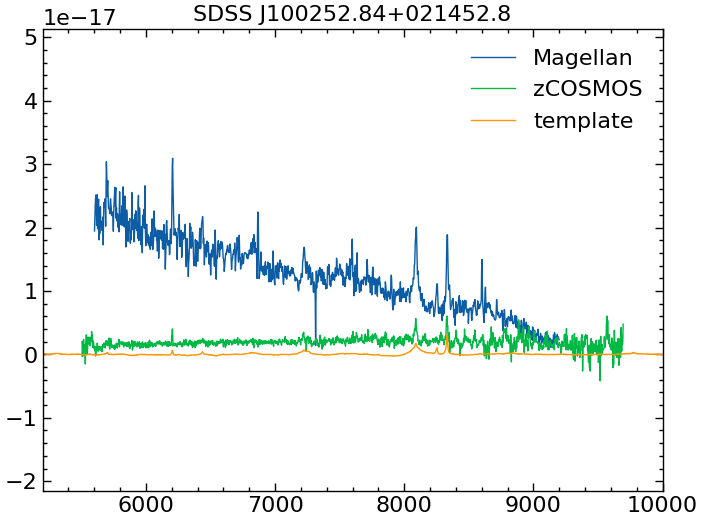

In [321]:
# SDSS J100252.84+021452.8 (6)

hdu1 = fits.open('spec/magellan_opt_100252+021452_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000821837_ZCMRa95_M1_Q2_16_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

# template
z=0.6633 # 0.6633: HSC AGN data
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17/5, label='template', linewidth=1)



plt.title('SDSS J100252.84+021452.8')
plt.xlim(5200, 10000)
plt.legend();

# hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']
SkyCoord(hdu1[0].header['RA']+' '+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+' '+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

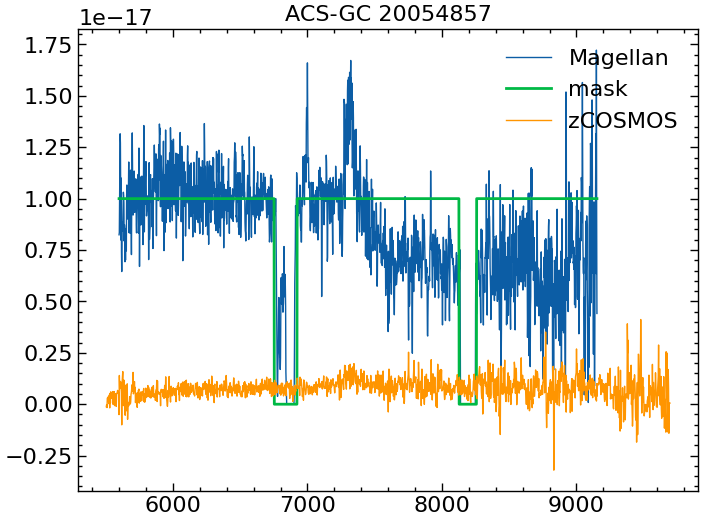

In [289]:
# ACS-GC 20054857

hdu1 = fits.open('spec/magellan_opt_100226+015940_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)
plt.plot(data1[0], data1[3]*1e-17, label='mask')

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000815962_ZCMRa83_M2_Q2_22_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

plt.title('ACS-GC 20054857')
plt.legend();

# hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']
# SkyCoord(hdu1[0].header['RA']+''+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
# SkyCoord(str(hdu2[0].header['RA'])+''+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
# SkyCoord('10h 02m 26.94s +01d 59m 40.1s')
# # SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

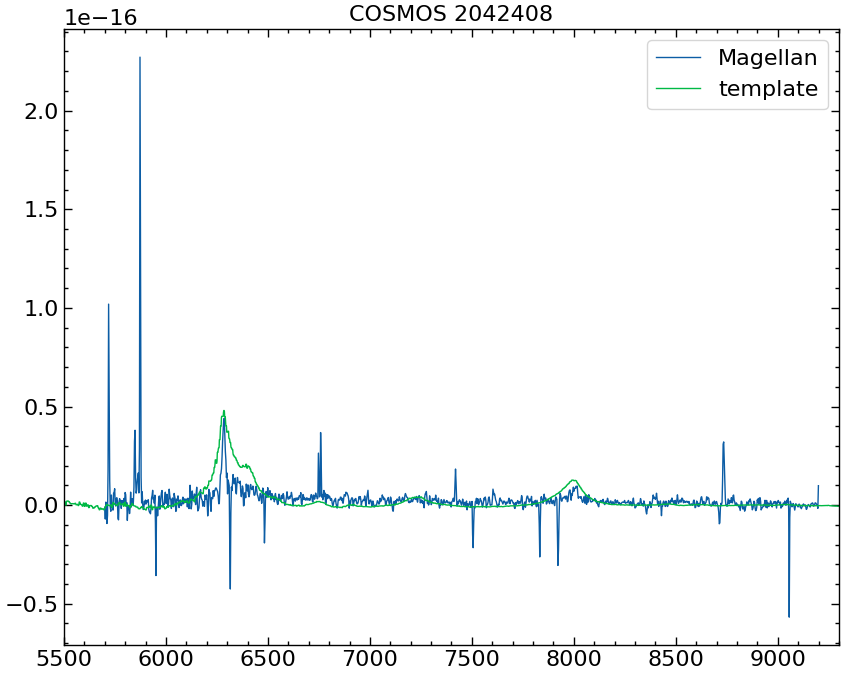

In [290]:
# COSMOS 2042408 (300)

plt.figure(figsize=[10, 8])

hdu1 = fits.open('spec/magellan_opt_095906+022639_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

z = 4.17
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17/5, label='template', linewidth=1)

plt.title('COSMOS 2042408')
plt.xlim(5500, 9300)
plt.legend(frameon=True);

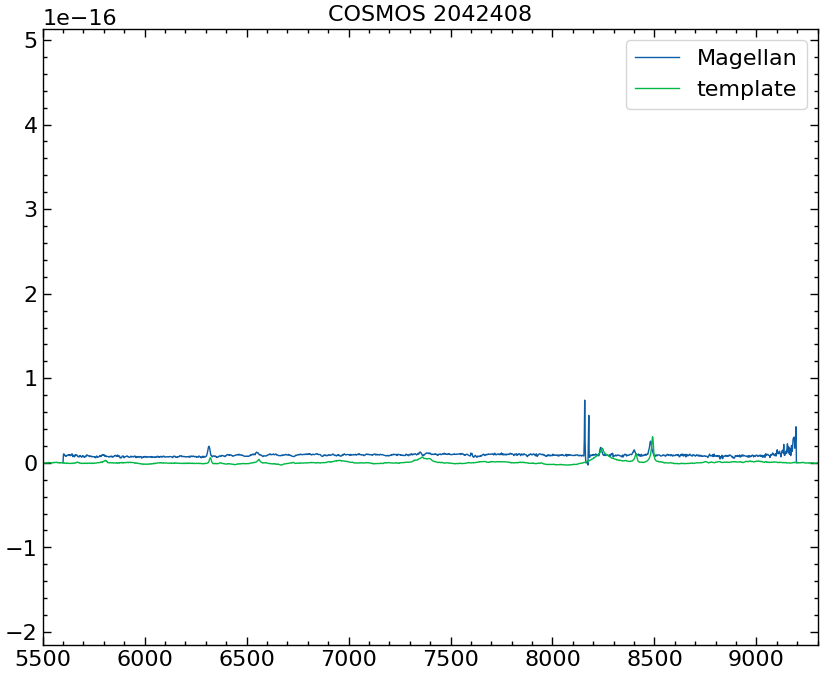

In [632]:
plt.figure(figsize=[10, 8])

hdu1 = fits.open('spec/Magellean/magellean_153.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

z = 0.695

hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-16/5, label='template', linewidth=1)

plt.title('COSMOS 2042408')
plt.xlim(5500, 9300)
plt.legend(frameon=True);

## DEIMOS

The data retrieval is as same as zCOSMOS, but download `deimos_redshift_linksIRSA.tbl`. 

**DEIMOS table contains possible spec-z value.**

In [642]:
deimos_targets = ascii.read('spec/deimos_redshift_linksIRSA.tbl')
# prettify
deimos_targets = deimos_targets[deimos_targets['fits1d']!='null']
pattern = re.compile(r'.*href="(.*)">.*')
for i in range(len(deimos_targets)): 
    for key in ['fits1d']: #, 'ascii1d', 'jpg1d', 'fits2d']: 
        # print(i, key)
        deimos_targets[key][i] = 'https://irsa.ipac.caltech.edu' + pattern.findall(deimos_targets[key][i])[0]

deimos_coords = SkyCoord(deimos_targets['ra'], deimos_targets['dec'], unit=[u.deg, u.deg])
idx_deimos, idx_data, d2d, _ = data_coords.search_around_sky(deimos_coords, 0.5*u.arcsec)

len(idx_deimos)

118

Update the downloading flag table 

In [651]:
data_agn_download['flag_deimos'] = False
data_agn_download['z_deimos'] = -1.

for i in range(len(data_agn_download)): 
    if i in idx_data: 
        data_agn_download['flag_deimos'][i] = True
        if deimos_targets['zspec'][i] not in ['0', 'NA']: 
            data_agn_download['z_deimos'][i] = deimos_targets['zspec'][i]

Download the data. The whole precess takes ~3 mins. UNCOMMENT IF YOU NEED TO DOWNLOAD AGAIN. 

Naming convention: `deimos_<ID>.fits` (ID not index)

In [ ]:
deimos_dir = 'spec/DEIMOS'
deimos_id = data_agn_download[idx_data]['ID']
deimos_links = deimos_targets[idx_deimos]['fits1d']

for i in range(len(deimos_id)): 
    os.system('wget '+deimos_links[i]+' -O '+os.path.join(deimos_dir, 'deimos_'+str(deimos_id[i])+'.fits'))

### Sample spectra

1.373


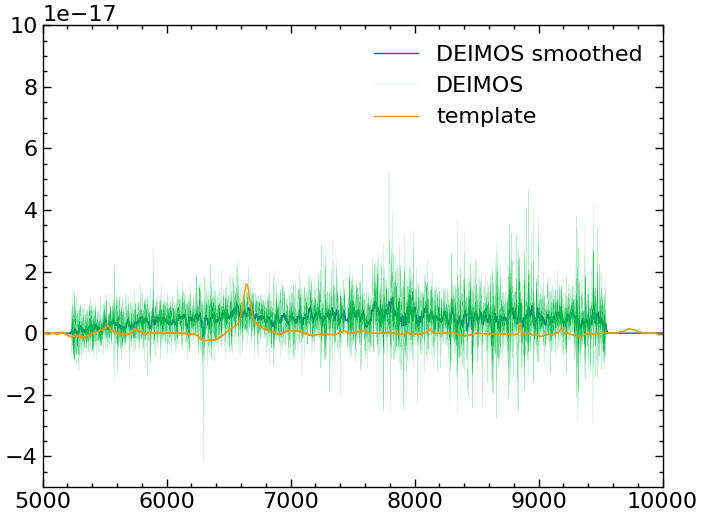

In [469]:
hdu3 = fits.open('spec/DEIMOS/deimos_59.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1)
plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-19, label='DEIMOS', linewidth=0.1)

# template
z = data_agn_updated['z'][58]
print(z)
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17, label='template', linewidth=1)

plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();

# deimos_targets[idx_deimos][np.where(data_agn_download[idx_data]['ID']==59)]['jpg1d']

## HSC

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

### Grab the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql
SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;
```

It will return a `csv` file that contains all the spec-z in COSMIS field. 

Then, we match our catalog to csv that contains its source. 

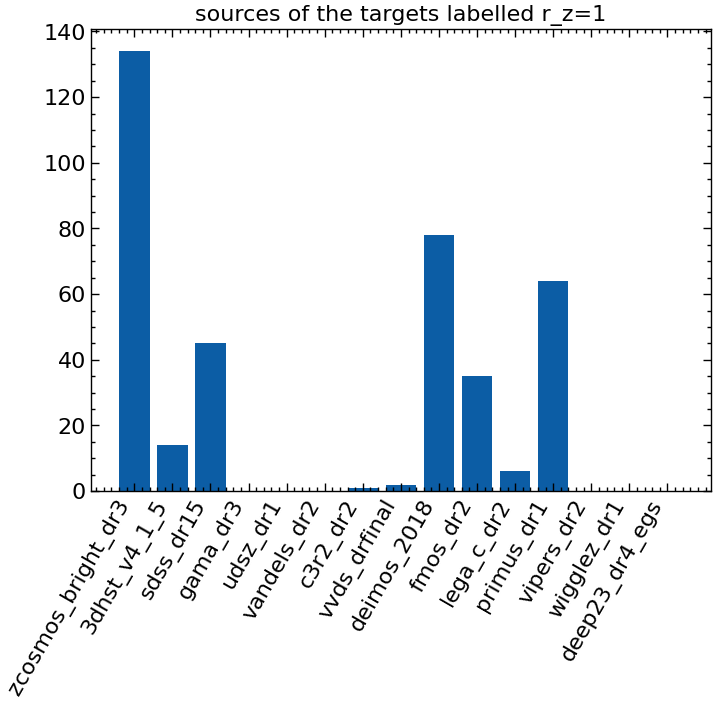

In [277]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('spec/420753.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, _ = data_coords[data_hsc_mask].search_around_sky(hsc_coords, 0.5*u.arcsec)

hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])

plt.bar([key[11:] for key in hsc_sources.keys()], hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of the targets labelled r_z=1');

TODO: check all the sources in HSC and download them

```
specz_flag_zcosmos_bright_dr3
specz_flag_3dhst_v4_1_5
specz_flag_sdss_dr15 
specz_flag_deimos_2018
specz_flag_fmos_dr2
specz_flag_primus_dr1
```


### Solve the inconsistent redshifts

Now, we can check which catalog the inconsistent data comes from. 

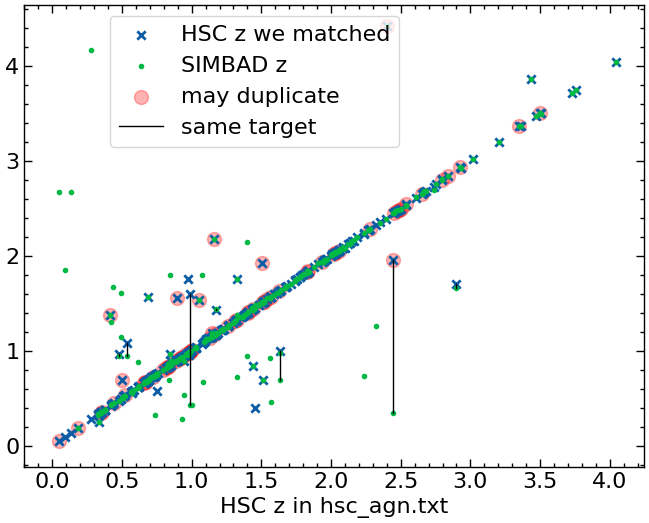

In [264]:
compare_mask = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']!=0
duplication_mask = hsc_targets[idx_hsc_pdr3]['specz_duplicationflag']!=100
match_mask = d2d<1*u.arcsec

plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'][match_mask & compare_mask], 
            marker='.', label='SIMBAD z')

# duplication flag
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & duplication_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & duplication_mask & compare_mask], 
            marker='o', label='may duplicate', alpha=0.3, zorder=0, c='r', s=100)

# check if we actually have 3 different values
x = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']
y1 = hsc_targets[idx_hsc_pdr3]['specz_redshift']
y2 = data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z']
for i in range(len(idx_hsc_pdr3)): 
    if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
        plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

1. Overlapping `.` and `x` but not in $y=x$ indicates that HSC z actually gives the same result as SIMBAD, which means that the HSC-z in `hsc_agn.txt` gives a wrong result than DR3. 

2. Single `.` means that HSC is indeed different from SIMBAD, and maybe `HSC` is wrong. We need to further examine where these dots fome from. 

3. Single `x` means that the data we matched and the data in `hsc_agn.txt` are different, but `hsc_agn.txt` gives the same result as SIMBAD. 

4. There are a few objects that has 3 values in 3 catalogs, all of which are duplicated sources. 

Ignore 0 values. These are the sources have no SIMBAD spectrum in good quality. 

"May duplicate" means that there is object(s) in HSC database within 0.5 arcsec. 

One possible reason for those off `x` (1. and 3.) is that they used L1 norm instead of cone search to match the catalog. 

#### For case 2, we check which database the inconsistent values come from. 

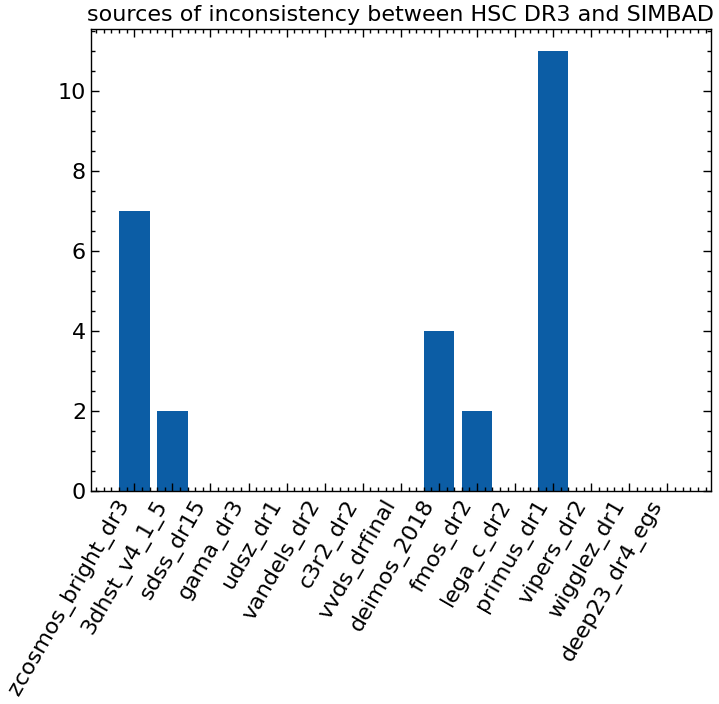

In [273]:
check_hsc_mask = (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - hsc_targets[idx_hsc_pdr3]['specz_redshift'])<0.05) & \
                 (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'])>0.05)

check_hsc_sources = {}
for key in source_keys: 
    check_hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][check_hsc_mask][key])

plt.bar([key[11:] for key in check_hsc_sources.keys()], check_hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of inconsistency between HSC DR3 and SIMBAD');

Plot the distribution of the bar chart above

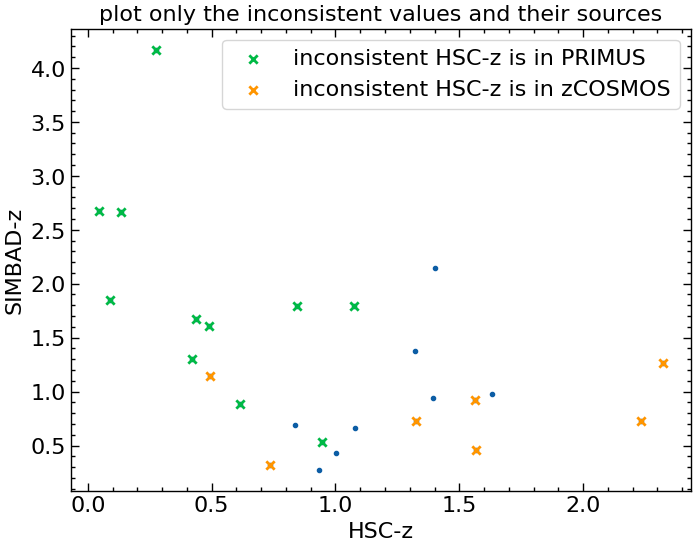

In [278]:
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'], 
        marker='.')
mask_primus = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_primus_dr1']==True
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_primus], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_primus], 
        marker='x', label='inconsistent HSC-z is in PRIMUS')
mask_zcosmos = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_zcosmos_bright_dr3']
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_zcosmos], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_zcosmos], 
        marker='x', label='inconsistent HSC-z is in zCOSMOS')
plt.xlabel('HSC-z')
plt.ylabel('SIMBAD-z')
plt.title('plot only the inconsistent values and their sources')
plt.legend(frameon=True);

TODO: Check with case 1 hsc_agn.txt and 3?

### Check with PDR2

The purpose of this subsection is to check if the 

codes are copied and slightly modified from the above 2 subsections. 

```sql
SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift

    FROM pdr2_dud.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;
```


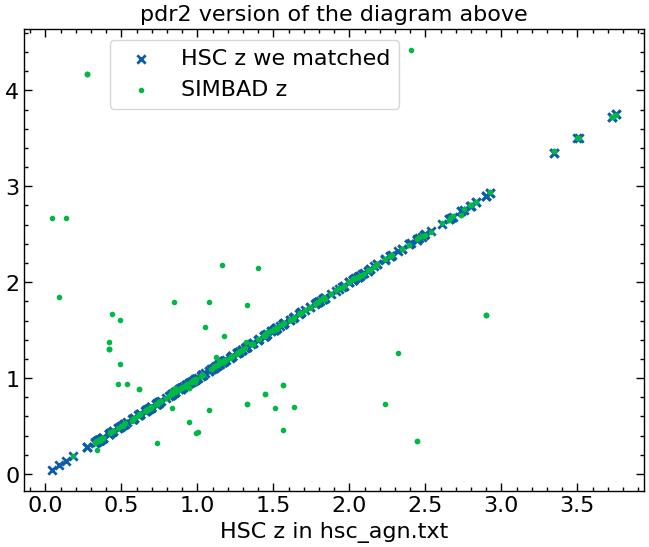

In [283]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

hsc_targets = ascii.read('spec/421976.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])

idx_hsc_pdr2, idx_hsc_specz, d2d, _ = data_coords[data_hsc_mask].search_around_sky(hsc_coords, 0.5*u.arcsec)

compare_mask = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']!=0

plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][compare_mask], 
            hsc_targets[idx_hsc_pdr2]['specz_redshift'][compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][compare_mask], 
            data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'][compare_mask], 
            marker='.', label='SIMBAD z')

# # check if we actually have 3 different values
# x = data_agn_compare[data_hsc_mask]['HSC-z']
# y1 = hsc_targets[idx]['specz_redshift']
# y2 = data_agn_compare[data_hsc_mask]['SIMBAD-z']
# for i in range(len(data_agn_compare[data_hsc_mask])): 
#     if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
#         plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
# plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.title('pdr2 version of the diagram above')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

There are many targets fail to match in our inquiry, but there is no in consistency observed between DR2 and `hsc_agn.txt`. 

### Check those suspiciously aligned phot-z

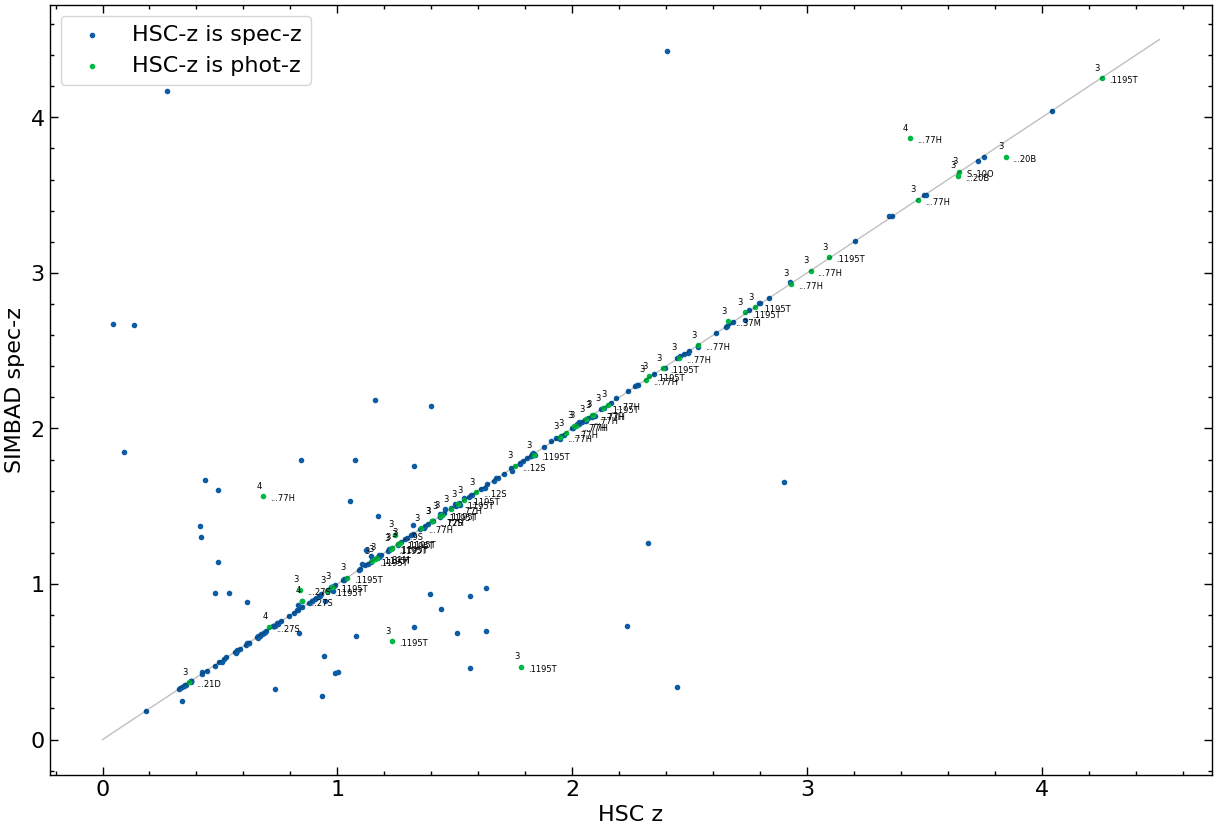

In [242]:
plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (data_agn_compare['r_HSC-z'][i]=='phot'): #(np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.03), size=6)
        plt.annotate(data_agn['r_z'][i], (data_agn_compare['HSC-z'][i]-0.03, data_agn_compare['SIMBAD-z'][i]+0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

Still, most data that has a `phot-z` label in HSC paper has a spec-z coming from zCOSMOS and DEIMOS.

In HSC paper, the `phot-z` comes form Chandra catalog (`2016ApJ...817...34M`) or COSMOS2015 catalog (`2016ApJS..224...24L`). 

For Chandra catalog, seems like 41% of its redsfhit is actually spec-z (chapter 6.1). 



## SDSS 

Download the spectra and label the table at once: 

In [ ]:
data_agn_download['flag_sdss'] = False
data_agn_download['z_sdss'] = -1. 
sdss_dir = 'spec/SDSS'

for i in range(len(data_agn_updated)): 
    pos = data_coords[i]
    xid = SDSS.query_region(pos, radius='3 arcsec', spectro=True)
    if xid is None: 
        continue
    if len(xid)>=2: 
        print(i+1, 'has multiple spectra: ')
        xid.pprint_all()
    else: 
        print(i+1, 'has a spectrum')
    data_agn_download['flag_sdss'][i] = True
    data_agn_download['z_sdss'][i] = xid['z'][-1]
    # sp = SDSS.get_spectra(matches=xid)
    # sp[-1].writeto(os.path.join(sdss_dir, 'sdss_'+str(data_agn_download[i]['ID'])+'.fits'), overwrite=True) # if more than 1, then the last one is probably the newest

Notes: 
* ID=283 and 280 have 2 spectra at its coordinate but their data are very close 
* If we change radius to 1 arcsec we can get more result with no overlapping 
* We should have more than 19 since our HSC catalog contains 45 targets in SDSS 
* It found 19, 30, 47, 58, 58, 58, 58, 59, 59 objects when I set the radius to 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5 arcsecs, so it may be good to set it to 3.0 arcsec. 

In [588]:
np.count_nonzero(data_agn_download['flag_sdss'])

58

### sample spectra

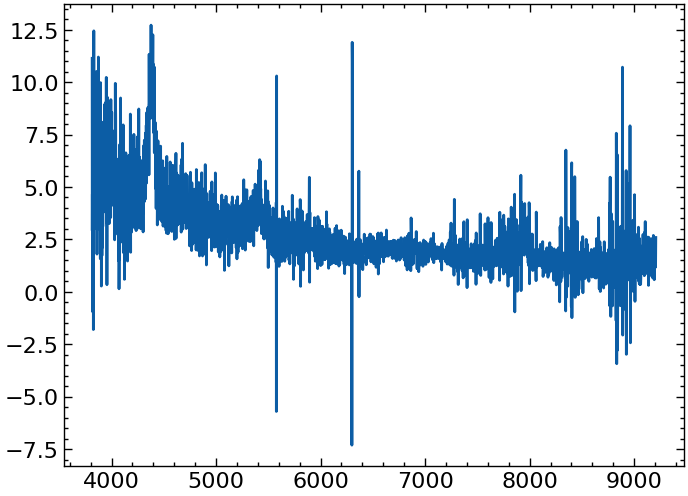

In [589]:
hdu = fits.open('spec/SDSS/sdss_155.fits')

plt.plot(10**hdu[1].data['loglam'], hdu[1].data['flux'])

## Summary

Check how many spectra each target has: 

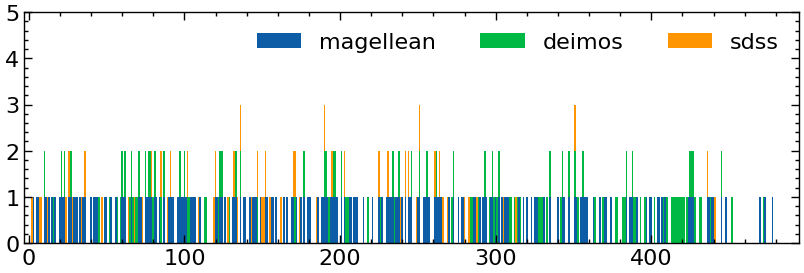

In [656]:
plt.figure(figsize=[10, 3])
spectra_counts = np.zeros(len(data_agn_download))
for flag in ['flag_magellean', 'flag_deimos', 'flag_sdss']: 
    plt.bar(data_agn_download['ID'], data_agn_download[flag], width=1, bottom=spectra_counts, label=flag[5:])
    spectra_counts += data_agn_download[flag]
plt.legend(ncol=4)
plt.xlim(-3, 495)
plt.ylim(0, 5);

# 


In [ ]:
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508,2020ApJ...894...24K
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.474,3,445280,-------------------


In [215]:
data_agn_compare

HSC-z,r_HSC-z,SIMBAD-z,bib_SIMBAD-z,name
float64,str4,float64,str19,str40
0.0,none,0.0,-------------------,--
3.499,spec,3.5026,2014A&A...563A..54P,SDSS J100256.53+021158.4
0.977,spec,0.979,2009ApJ...696.1195T,SDSS J100256.04+020923.2
0.573,spec,0.5727,2018A&A...611A..53J,COSMOS2015 552225
0.585,spec,0.5824,2009ApJ...696.1195T,SDSS J100307.82+021134.9
0.664,spec,0.6652,2009ApJ...696.1195T,SDSS J100252.84+021452.8
1.964,spec,1.9555,2009ApJ...696.1195T,[VV2006] J100309.2+022038
1.999,spec,2.0051,2009ApJ...696.1195T,[VV2006] J100251.7+022905
0.0,none,0.0,-------------------,--


In [ ]:
from astropy.table import Table
Table.read('spec/420753.csv', format='csv', converters={'specz_flag_zcosmos_bright_dr3': [ascii.convert_numpy(bool)]})

# object_id,specz_ra,specz_dec,specz_redshift,specz_duplicationflag,specz_flag_zcosmos_bright_dr3,specz_flag_3dhst_v4_1_5,specz_flag_sdss_dr15,specz_flag_gama_dr3,specz_flag_udsz_dr1,specz_flag_vandels_dr2,specz_flag_c3r2_dr2,specz_flag_vvds_drfinal,specz_flag_deimos_2018,specz_flag_fmos_dr2,specz_flag_lega_c_dr2,specz_flag_primus_dr1,specz_flag_vipers_dr2,specz_flag_wigglez_dr1,specz_flag_deep23_dr4_egs
int64,float64,float64,float64,int64,bool,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5
43158734788123154,150.10261536,2.20605063,1.0276,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349173942,150.18032837,2.21132898,0.65367,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349174975,150.20129395,2.21717215,2.0717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127382,150.13301086,2.22695804,0.9522,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127788,150.11584473,2.22766662,1.9218,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788135679,150.0609436,2.28366518,0.22569,10,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349178065,150.18655396,2.24057221,0.9281,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788131569,150.08352661,2.2660706,1.4717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349182175,150.15930176,2.26882362,3.0932,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
